# 07.01 Regression

Regression is different from classification in that it tries to predict continuous values.
In other words, we are predicting a value instead of classes or labels.
Regression is somewhat older than classification, and stems from experimental science,
which collected data in the attempt to find mathematical representations
(functions) of natural phenomena.
During that period regression was (and often still is) called *function approximation*.
The simplest form of regression is the *least squares* technique.

![Car Driving](fe-driver.svg)

<div style="text-align:right;"><sup>fe-driver.svg</sup></div>

Let's say that we performed an collected experimental data.
This data is likely to be an insight into a process about which we want to learn.
Yet, the data is incomplete and ridden with experimental error,
making it hard to recreate the process that was measured.
In the simplest case we'd like to find a line $y = w_1x + w_0$ which
*we assume* would be a good approximation of the process.

Note: There are several notations used for linear regression or function approximation.
Some literature will draw the line equation as $f(x) = ax + b$, others as $y = a_0 + a_1x$,
or a combination of these notations.
In Machine Learning most people prefer to use $w$ to denote the parameters,
a mnemonic to *weight*.  In this notation we write the line equation as $y = w_1x + w_0$.

`sklearn`'s `LinearRegression`, by default, performs a least squares approximation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Road Trip

As a simple example we can **estimate the mean speed** on a road curve by **measuring
the position** of every car starting from the entry into the curve $(t = 0)$.
Let's say we got the following measures.

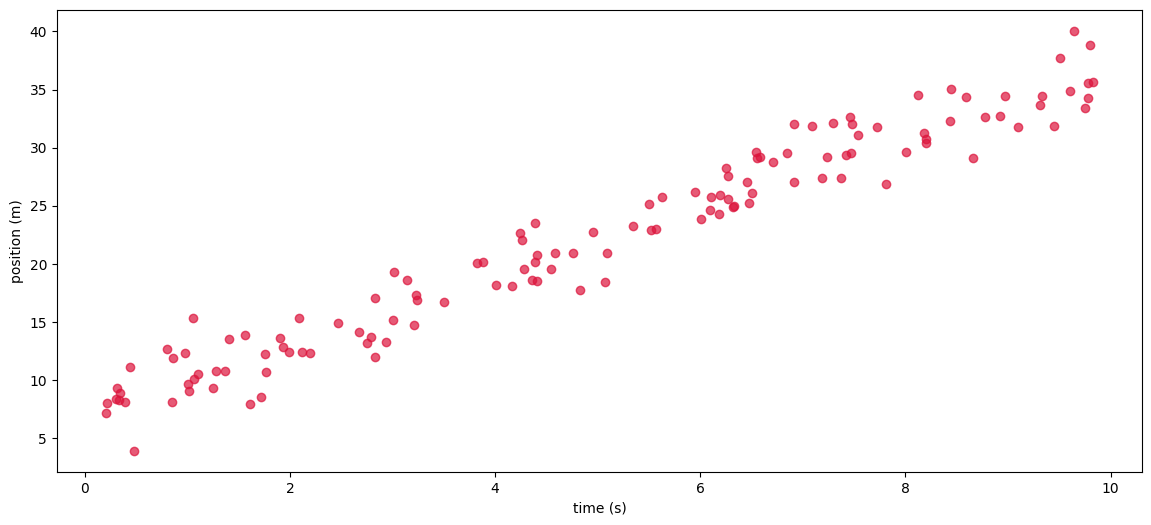

In [2]:
t = 10*np.random.rand(128)
pos = 7 + t*3 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(t, pos, 'o', color='crimson', alpha=0.7)
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)');

Note that by out variable naming `t` $= x$ and `pos` $= y$.

Least squares attempts to minimize the error (residual) across all points:

$$r = \sum_{i=1}^{N} (f(x_i) - y_i)^2 = \sum (f(\vec{X}) - \vec{y})^2$$

We can say that we are minimizing the error of the point to a function of the form:

$$y = w_1x + w_0$$

The notation using $w$s is typical for machine learning - standing for weights,
statistics would often use $\beta$s and physicists would use several letters
such as $a$, $b$, $c$ and so on.
One will need to get used to such changes in notation,
until the point where - having seen enough different texts - one does
not even consider a change in letters a change in notation.

The minimization, in two dimensions, can be understood as (here $X$, $w$ and $y$ are vectors):

$$\min_{w} \|Xw - y\|$$

For the case of a line $y = w_1x + w_0$ we search for the parameters $w_0$ and $w_1$,
and these can be found analytically.
There are several ways of getting to these equations,
one of them is to walk the function formed by the residuals for all values of $w_0$ and $w_1$.
The surface of the parameters $w_0$ and $w_1$ is concave,
therefore exist a single point where the gradient is exactly zero.
Form this point we get.

$$
w_0 = \frac{\overline{y} \sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_iy_i}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}\\
w_1 = \frac{\sum_{i=0}^{n} x_iy_i - n \overline{x} \overline{y}}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}
$$

In our case $w_1$ is the *mean speed* we are after.  `sklearn` will do the calculation for us.
The linear regression in `sklearn` produces the resulting parameters as `intercept_` containing $w_0$
and `coef_` containing $w_1, w_2, ...$ (for example, in the case where we have more dimensions).
Compare these to the values we used to generate the data.

(np.float64(7.130276348847925), array([2.99812671]))

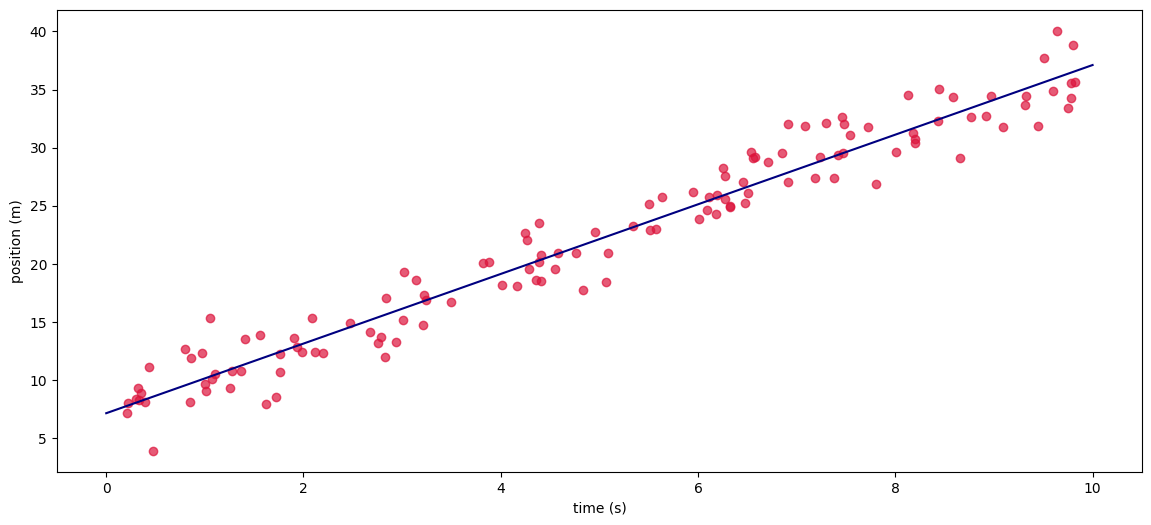

In [3]:
model = LinearRegression()
model.fit(t[:, np.newaxis], pos)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(t, pos, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)')
model.intercept_, model.coef_

Now we know how to **measure the mean speed** (assuming that we can compare positions very quickly).
But what if we want the **typical speed at each point** across more than just a single curve?
Let's generate some data that is akin of:

1. Slowing down before turn.
2. Gaining speed slowly in the turn.
3. Gaining speed faster after exiting the curve.

Note that the axis labels have changed.
Now we know how to measure the mean speed,
we are advancing towards a curve in which the speed changes.

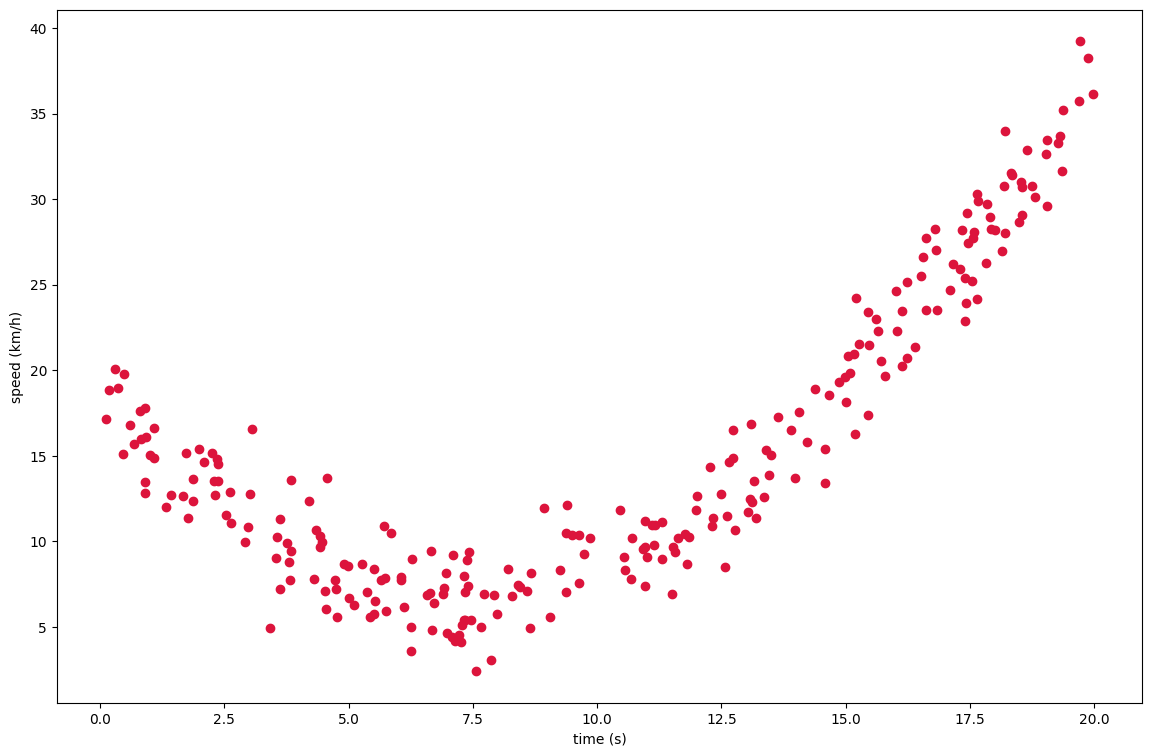

In [4]:
t = 20*np.random.rand(256)
spd = 7 + 0.2*(t-7.5)**2 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)');

That kind of looks like a function akin of:

$$y = w_2x^2 + w_1x + w_0$$

The traditional (read: non-computational) method to solve this problem is to get rid of $x^2$
by applying a logarithmic transformation to the axes, and then apply the linear
regression as normal since the graph would be a line.  For example:

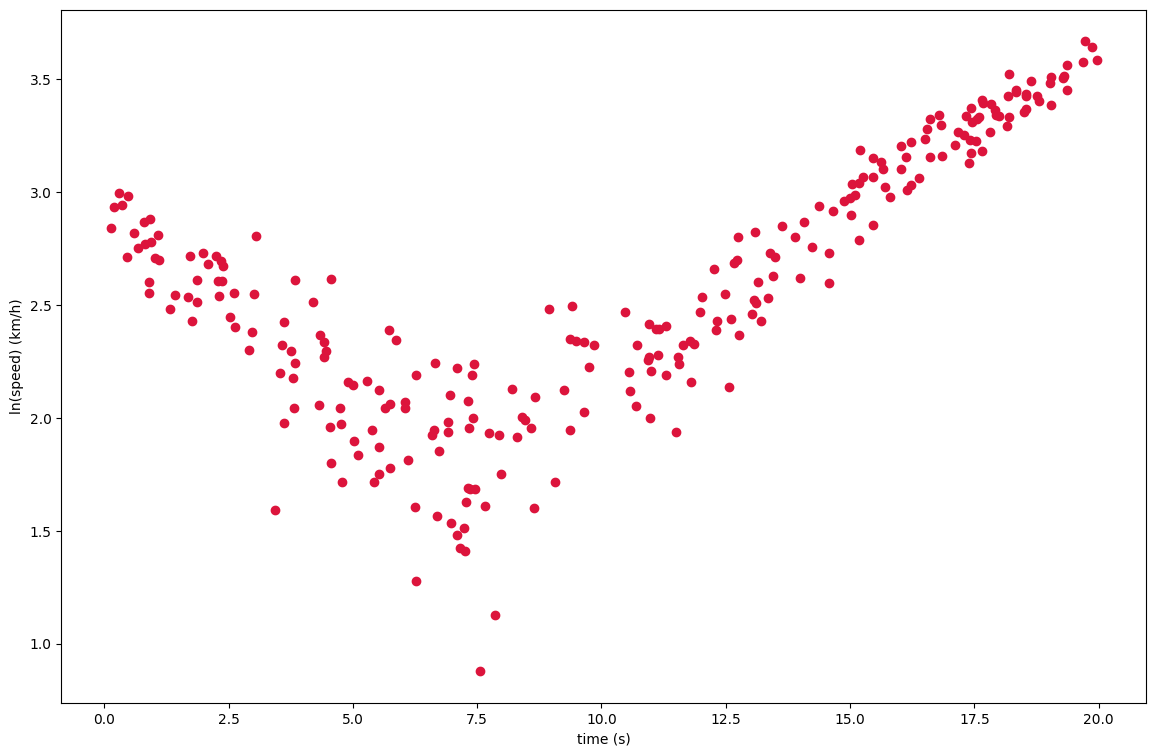

In [5]:
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(t, np.log(spd), 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('ln(speed) (km/h)');

We can now divide our data at, say, $t = 7.5$ and generate two linear regressions,
one for each side.  But there are better ways!

Since we can easily operate in more than two dimensions (time and speed in our case)
let's build this same model in three dimensions: time, speed *and speed squared*.
`sklearn` provides us with `PolynomialFeatures` preprocessor for such cases.

In more dimensions we will search for more coefficients.
The general least squares equation can compe with as many dimensions as we need:

$$\min_{w_1, \dots, w_{d - 1}} \|Xw_j - y\|$$

Which is analogous to:

$$f(x_0, x_1, \dots, x_i) = w_0 + w_1x_0 + w_2x_1\dots + w_ix_{i-1} + w_{i+1}x_i$$

Where a single coefficient is multiplies by each dimension (each axis).
But nothing prevents us from doing the following,
i.e. use the same dimension twice, with a tweak:

$$f(x) = w_0 + w_1x + w_2x^2$$

This is still a linear model since neither $w$ parameter multiplies each other.
`sklearn`'s `PolynomialFeatures` can transform the data for us
(instead of us doing it by hand).

In [6]:
from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=2)
pol.fit_transform(t[:, np.newaxis])[:10, :]

array([[  1.        ,   1.42401133,   2.02780826],
       [  1.        ,  11.98719256, 143.69278551],
       [  1.        ,   5.37814251,  28.92441681],
       [  1.        ,  16.2277474 , 263.33978563],
       [  1.        ,   0.89701463,   0.80463525],
       [  1.        ,   6.72295062,  45.19806508],
       [  1.        ,   7.56232327,  57.18873319],
       [  1.        ,  17.92858617, 321.43420223],
       [  1.        ,   5.52219881,  30.49467966],
       [  1.        ,   7.66618444,  58.7703838 ]])

That looks good, we have a matrix of parameters for $t^0, t^1 t^2$,
now we can fit a line to that and then multiply by these parameters
again when we `perdict` the result.
Remembering to multiply things back when predicting is something that `sklearn` can do for us.
We use a **pipeline** which joins one - or more - preprocessors with an estimator,
in this case we join the polynomial features with the linear regression.
The `make_pipeline` procedure takes several `sklearn` objects,
that contain `fit`, `transform` and `predict` methods,
and joins them together.
This is what a Polynomial Regression is below the hood.

In a pipeline `P` of say three objects `A`, `B` and `C` when one calls
`P.fit(X, y)` it is equivalent to call
`C.fit(*B.fit_transform(*A.fit_transform(X, y)))`.
And a call such as `P.predict(X)` is equivalent as one would do
`C.predict(B.transform(A.transform(X)))`.
The pipeline just reduces the amount of typing one needs to do.
`sklearn` also knows how to access individual parts of the pipeline,
and will have shortcuts for us whenever we will need to
access parts of the pipeline.

We now have one *hyperparameter* in our model, the degree of the polynomial.
That said, we are rather confident that we are after a 2nd degree polynomial,
therefore we probably know the best value for that hyperparameter.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

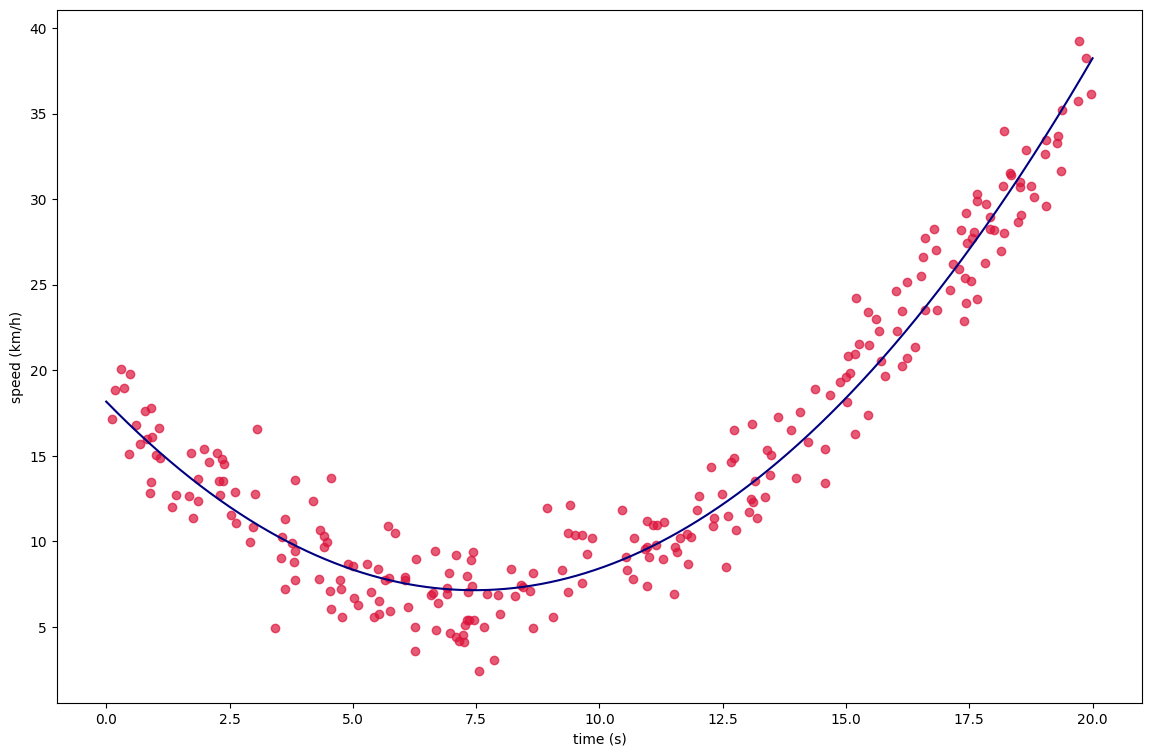

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 20, 2000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(14, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

And to get the values for $w_0$, $w_1$ and $w_2$ as in the function we defined.

$$f(x) = w_0 + w_1x + w_2x^2$$

We just check for the parameters in the model.
These can be again compared to the values we used to generate the data,
although this time it may be a little harder since we used some brackets
to group the equation.
Since we used polynomial features there is a zero in the `coef_` array,
this is a placeholder for the intercept value which is held in `intercept_`.

In [8]:
model.named_steps.linearregression.intercept_, model.named_steps.linearregression.coef_

(array([18.16505638]), array([[ 0.        , -2.95374617,  0.19785842]]))

We are confident, by-eye, that our estimation is good.
Still, let's be careful and evaluate how our model performs on unknown data.

Each model type in `sklearn` contains a `score` method,
which contains a scoring method appropriate for a common model of that type.
On classification models it will contain the mean accuracy or F1 score.
For the linear regression the scoring is the [Coefficient of Determination (R2)][r2score]:
the residual error after regression divided by the total regression error

[r2score]: https://en.wikipedia.org/wiki/Coefficient_of_determination

In statistics it is often argued that $R2$ ranges from $0$ to $1$.
But that is under the assumption that no model will ever perform worse
than always outputting the mean of the data.
In machine learning one can build a model that performs worse than
such a mean outputting model,
hence negative values of $R2$ happen.

In [9]:
from sklearn.model_selection import train_test_split

t1, t2, s1, s2 = train_test_split(t, spd, train_size=0.7, test_size=0.3)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(t1[:, np.newaxis], s1[:, np.newaxis])
model.score(t2[:, np.newaxis], s2[:, np.newaxis])

0.9465577695991676

## Cross Validation

The score varies depending on how the training and test sets are selected.
Therefore, in order to get a good sense on how the model performs,
we should repeat the train-test split and perform the scoring at each split.

Yet, `sklearn` has automated that for us  with `cross_val_score`, a way of splitting data
into training and test sets in several part and then scoring each pair.
This concept is called **cross-validation** and is prominent in all of machine learning.
In cross validation we split the data into equally sized folds,
then train the model on all folds but one and then evaluate (score) the model
on the remaining fold.
We then repeat the procedure with every fold being left out as the testing set once.

By default `cross_val_score` will simply split the data into adjacent folds,
one can pass, say, `cv=7` as an argument to split into $7$ adjacent folds.
Splitting into adjacent folds does not involve randomness,
as it has been the case when we used `train_test_split`.
This is a good procedure when the data one is dealing with is presented
to the model in a random order,
i.e. if the dataset has no particular order of values or labels.
In most cases datasets have order, e.g. one label is at the top of
the dataset and another at the bottom.
In order to remove the impact of data ordering we can define how folds
of the data are created.
We pass as the argument to `cv=` a `KFold` object which defines how the folds
are to be created.
In the case below we ask for $5$ folds, and also ask for the data to be shuffled
(at random) before the fold creation,
preventing the impact of any order of samples within the dataset.

In [10]:
from sklearn.model_selection import cross_val_score, KFold

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
cross_val_score(model, t[:, np.newaxis], spd[:, np.newaxis], cv=KFold(n_splits=5, shuffle=True))

array([0.92401629, 0.9482034 , 0.90060408, 0.96939898, 0.95149461])

Depending on our needs we can take the mean or the lowest value
to estimate the performance of our model.
If we have lots of data, taking the minimum value is a good measure
since it may account for entire groups of data that are badly learned.
But if we have very few data points a mean is more meaningful,
as a single low value may be a case of few outliers - possibly
mistakes in the dataset itself.

Now we can reasonably say that we are confident in our model.
In other words, thanks to the cross-validation scores,
we are confident that our model can reasonably predict values for new input data.
In machine learning we often say that our model can **generalize** well
to previously unknown data.